# Lab 6 - CNNs
#### Liam Lowsley-Williams, Fernando Vázquez


## Introduction

For this lab, we chose to use an image based dataset for road sign classification. We used a data set that consisted of __[number]__ of images across 43 different classifications of traffic signs. The traffic signs included but were not limited to speed signs, stop signs, children crossing signs, and etc. Our primary interest is to classify a particular sign (such as speed) accurately for updating navigation apps to include speed data. We are also interested in beginning to explore the possibilities of real-time autodetection of these signs for autonomous driving.

## Business Case

### Motivation

The drive for automation is stronger now than it ever has been before. We have expanded to automate not only industrial applications but now our own households and everyday environments too. From smart homes to driving, the innovations are endless and usually very beneficial. The area we are focusing on in this lab is automation when it comes to driving and driving utilities. Many navigation apps today such as Waze or Google Maps now include speed data directly in the app for many popular roads around the world. The idea behind our use case is to develop a neural network that shows promising ability to classify these signs and use it to update map speed data via user’s iphones. This would allow Google to collect sign data information from users on millions of roads across the U.S. that could be used for updating their app to provide useful and up to date information.

The other motivation here is to begin exploring the possibility of developing an autonomous detection system for speed signs to self regulate autonomous vehicles. This could prove to be immensely useful in the rapidly-expanding industry of self-driving cars. Using existing DOT data on road information along with real time detection could seriously improve the safety and performance of self-driving cars on the road. 

### Objective

Our objective in this lab is to construct a neural network that is capable of classifying road signs correctly. We will be using accuracy as our metric (discussed later) and given our application is related to driving motor vehicles on government roads, our model must be extremely accurate as a mis-classification could be extremely dangerous. However, the measure of accuracy does not have to reflect all classes. It could be focused on a subset group such as speed sign classification. That being said, the metric must still perform extremely well regardless of the subset. We are aiming to reach a performance of above at least 90% to satisfy the map navigation use case and a near perfect score for consideration of using such a model for real time detection.

### Evaluation

### Data Prep Explanation

## Function & Package Intialization
#### DONT FORGET TO SWITCH KERNEL TO GPU!!!

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.0.0
Default GPU Device: /device:GPU:0


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import pickle
import numpy as np

# graph visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.__version__

Using TensorFlow backend.


'2.3.1'

In [3]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(45,20))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

def cnn_heatmap(cnn, X_test, y_test):
    plt.figure(figsize=(45,20))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))

## Data Processing

### TRAFFIC PREPROCESS

In [18]:
# select random images to visualize
import random
random.seed(1)

# function to plot images in grid like fashion
def plot_gallery(images, title, h, w, n_row=4, n_col=8):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = random.sample(range(0,images.shape[0]), k=32)
    n = 0
    for i in rand_sample:
        plt.subplot(n_row, n_col, n + 1)
        plt.imshow(images[i][0])
        plt.title(title[i], size=12)
        plt.xticks(())
        plt.yticks(())
        n = n+1

In [19]:
file = open("./data/traffic/data0.pickle", "rb")
data = pickle.load(file) 

In [20]:
X_train_tr = data['x_train']
X_test_tr = data['x_test']
y_train_tr = data['y_train']
y_test_tr = data['y_test']

In [21]:
np.transpose(X_train_tr[500], (2, 1, 0)).shape

(32, 32, 3)

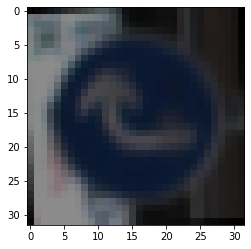

In [22]:
# np.transpose(img, (1, 2, 0))

plt.imshow(np.transpose(X_train_tr[500], (2, 1, 0)), interpolation='nearest')

# plt.imshow(X_train_tr[500][2], interpolation='nearest')


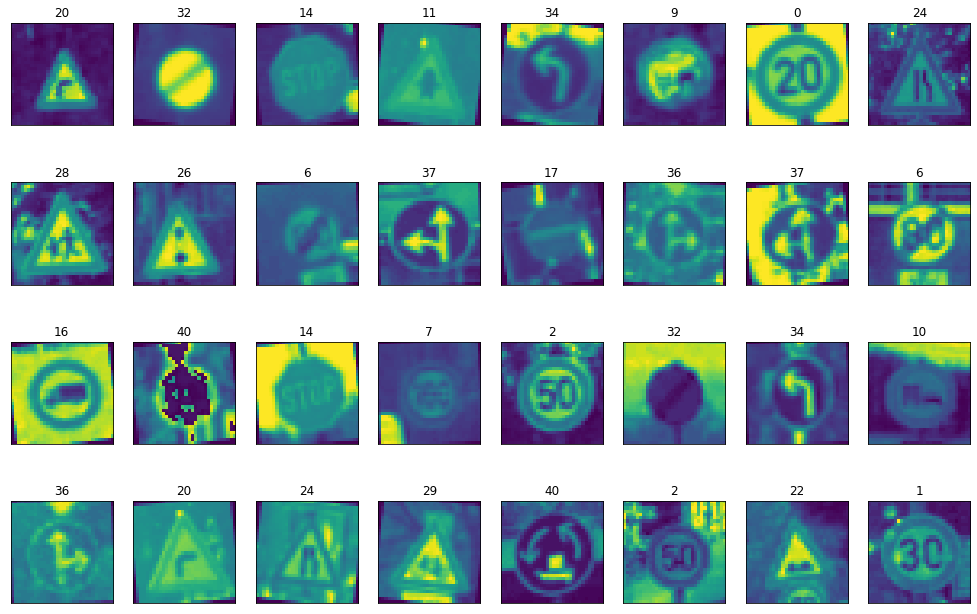

In [23]:
plot_gallery(X_train_tr, y_train_tr,32,32)

In [24]:
X_train_tr.shape

(86989, 3, 32, 32)

In [25]:
X_train_tr[0].shape

(3, 32, 32)

In [26]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=8, # used, Int. Degree range for random rotations.
    width_shift_range=0.2, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.2, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    data_format='channels_first',
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train_tr)

In [27]:
tmps = datagen.flow(X_train_tr, y_train_tr, batch_size=1)
count=0
xdata=[]
ydata=[]
for tmp in tmps:
    #tt=np.transpose(tmp[0].squeeze(), (1, 2, 0))
    tt=tmp[0].squeeze()
    tt=tt.astype('uint8')
    xdata.append(tt)
    ydata.append(tmp[1][0])
    #print(tt.shape)
    #plt.imshow(out.astype('uint8'))
    #print(tt)
    #print(tmp[1][0])
    #imshow(tt,cmap='bone')
    
    #plt.title(classes[np.argmax(tmp[1])])
    count+=1
    if count==10000:
        break
        
xdata=np.asarray(xdata, dtype=np.float32)
ydata=np.array(ydata)
# print("xdata shape: ",xdata.shape)
# print("ydata shape: ",ydata.shape)
# ydata[0]

print("X_train_tr shape: ",X_train_tr.shape)
print("y_train_tr shape: ",y_train_tr.shape)

X_train_tr = np.append(X_train_tr, xdata, axis=0)
y_train_tr = np.append(y_train_tr, ydata)

print("\nOnce expanded data is added")
print("X_train_tr shape: ",X_train_tr.shape)
print("y_train_tr shape: ",y_train_tr.shape)

X_train_tr shape:  (86989, 3, 32, 32)
y_train_tr shape:  (86989,)

Once expanded data is added
X_train_tr shape:  (96989, 3, 32, 32)
y_train_tr shape:  (96989,)


In [28]:
#Some data Normalization
X_train_tr = X_train_tr/255 - .5
X_test_tr = X_test_tr/255 - .5

In [29]:
y_train_ohe_tr = keras.utils.to_categorical(y_train_tr, 43)
y_test_ohe_tr = keras.utils.to_categorical(y_test_tr, 43)

## Modeling

In [14]:
## QUESTIONS ##
'''
1. Is the way we are feeding data into CNN correct?
2. Reccomendations on structures that will work well with our data? How to go about constructing them?
3. Which params exactly are the ones we should tune?
4. How would we go about data expansion if we use the preprocessed pickle files? Can we perform on data8
   which has shuffling, histogram equalization, and mean + std normalization? (not flattened)
5. Ask about which activation functions should be linear or relu
6. If we use the "validation_data" param, as seen below (curently uses the test data to validate), do we 
   need to use a third validation data set? If so, then where do we predict that? After the fit?
'''

'\n1. Is the way we are feeding data into CNN correct?\n2. Reccomendations on structures that will work well with our data? How to go about constructing them?\n3. Which params exactly are the ones we should tune?\n4. How would we go about data expansion if we use the preprocessed pickle files? Can we perform on data8\n   which has shuffling, histogram equalization, and mean + std normalization? (not flattened)\n5. Ask about which activation functions should be linear or relu\n6. If we use the "validation_data" param, as seen below (curently uses the test data to validate), do we \n   need to use a third validation data set? If so, then where do we predict that? After the fit?\n'

### Architecture 1 - Param Set 1

In [31]:
%%time
'''
INIT ARCHITECTURE
'''
img_sz = 32 # width and height of img

cnn1 = Sequential()

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                     kernel_size=(3,3), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(43, activation='softmax') )

cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

Wall time: 16 ms


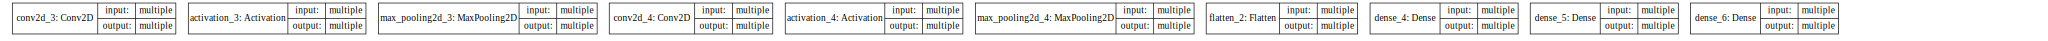

In [33]:
SVG(model_to_dot(cnn1, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [34]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn1_hist = cnn1.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Train on 96989 samples, validate on 12630 samples
Epoch 1/15
96989/96989 [==============================] - 26s 268us/step - loss: 0.0101 - accuracy: 0.6550 - val_loss: 0.0050 - val_accuracy: 0.8500
Epoch 2/15
96989/96989 [==============================] - 24s 250us/step - loss: 0.0038 - accuracy: 0.8833 - val_loss: 0.0042 - val_accuracy: 0.8778
Epoch 3/15
96989/96989 [==============================] - 22s 227us/step - loss: 0.0029 - accuracy: 0.9070 - val_loss: 0.0035 - val_accuracy: 0.8991
Epoch 4/15
96989/96989 [==============================] - 18s 185us/step - loss: 0.0025 - accuracy: 0.9183 - val_loss: 0.0037 - val_accuracy: 0.8903
Epoch 5/15
96989/96989 [==============================] - 18s 183us/step - loss: 0.0023 - accuracy: 0.9259 - val_loss: 0.0032 - val_accuracy: 0.9089
Epoch 6/15
96989/96989 [==============================] - 18s 184us/step - loss: 0.0021 - accuracy: 0.9318 - val_loss: 0.0036 - val_accuracy: 0.8999
Epoch 7/15
96989/96989 [==============================] 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


Text(0.5, 0, 'epochs')

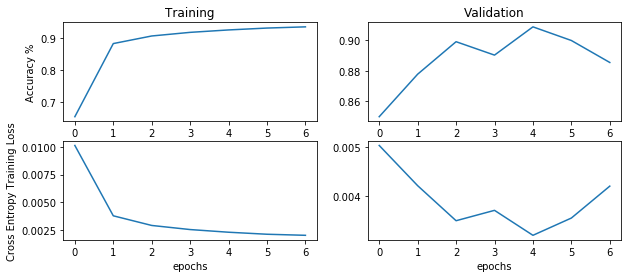

In [35]:
print(cnn1_hist.history.keys())
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn1_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn1_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn1_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn1_hist.history['val_loss'])
plt.xlabel('epochs')

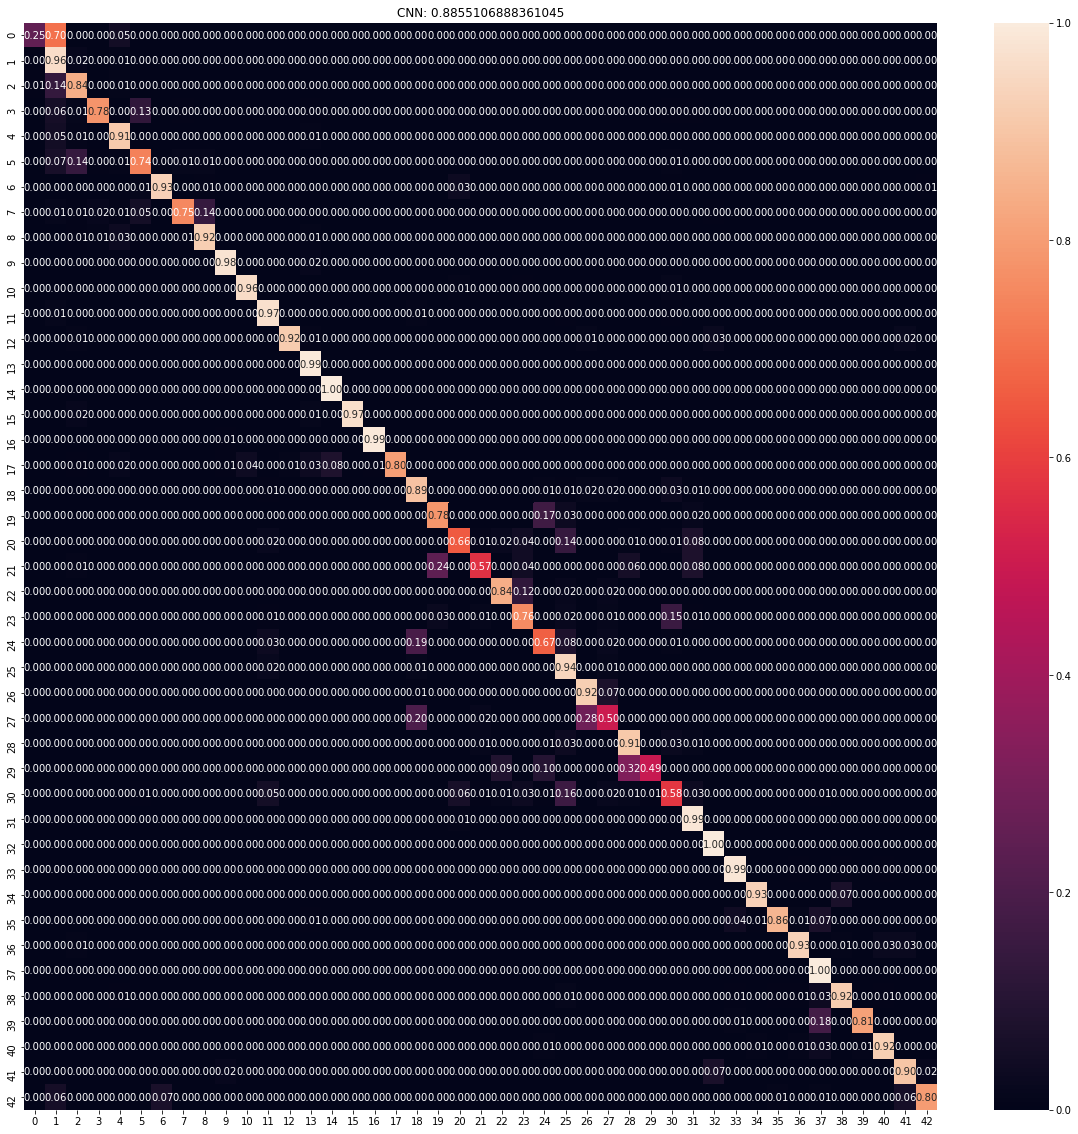

In [36]:
cnn_heatmap(cnn1,X_test_tr,y_test_tr)

As seen above, our first model performs quite well on the train and test data. There may be a bit of evidence suggesting overtraining here as the validation begins to degrade with further epochs. That being said, the model performs to the expectations we initially set forth for the maps application, there would need to be some more improvement before considering it for autonomous driving. 

### Architecture 1 - Param Set 2

In [37]:
%%time
'''
CHANGES:
 - DOUBLED SIZE OF SECOND FILTER LAYER
 - INCREASED SIZE OF KERNEL TO (4,4)
 - CHANGED THE ACTIVATION FUNCTION IN THE 2 DENSE LAYERS TO LINEAR
'''

img_sz = 32 # width and height of img

cnn2 = Sequential()
num_filt_layers = [24, 48]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters, 
                     kernel_size=(4,4), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn2.add( Activation('relu'))
    cnn2.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    
cnn2.add( Flatten() )
cnn2.add( Dense(100, activation='linear') )
cnn2.add( Dense(100, activation='linear') )
cnn2.add( Dense(43, activation='softmax') )

cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

Wall time: 196 ms


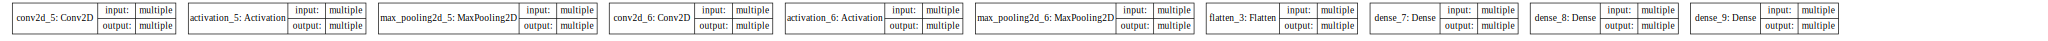

In [38]:
SVG(model_to_dot(cnn2, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [39]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn2_hist = cnn2.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Train on 96989 samples, validate on 12630 samples
Epoch 1/15
96989/96989 [==============================] - 19s 200us/step - loss: 0.0074 - accuracy: 0.7619 - val_loss: 0.0034 - val_accuracy: 0.9042
Epoch 2/15
96989/96989 [==============================] - 19s 198us/step - loss: 0.0035 - accuracy: 0.9001 - val_loss: 0.0024 - val_accuracy: 0.9332
Epoch 3/15
96989/96989 [==============================] - 20s 205us/step - loss: 0.0031 - accuracy: 0.9132 - val_loss: 0.0022 - val_accuracy: 0.9405
Epoch 4/15
96989/96989 [==============================] - 20s 204us/step - loss: 0.0029 - accuracy: 0.9200 - val_loss: 0.0027 - val_accuracy: 0.9260
Epoch 5/15
96989/96989 [==============================] - 20s 202us/step - loss: 0.0028 - accuracy: 0.9241 - val_loss: 0.0029 - val_accuracy: 0.9229
Wall time: 1min 38s


Text(0.5, 0, 'epochs')

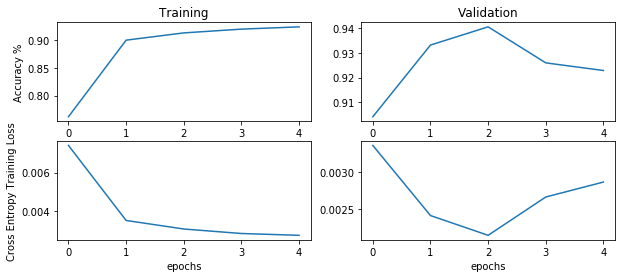

In [40]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn2_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn2_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn2_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn2_hist.history['val_loss'])
plt.xlabel('epochs')

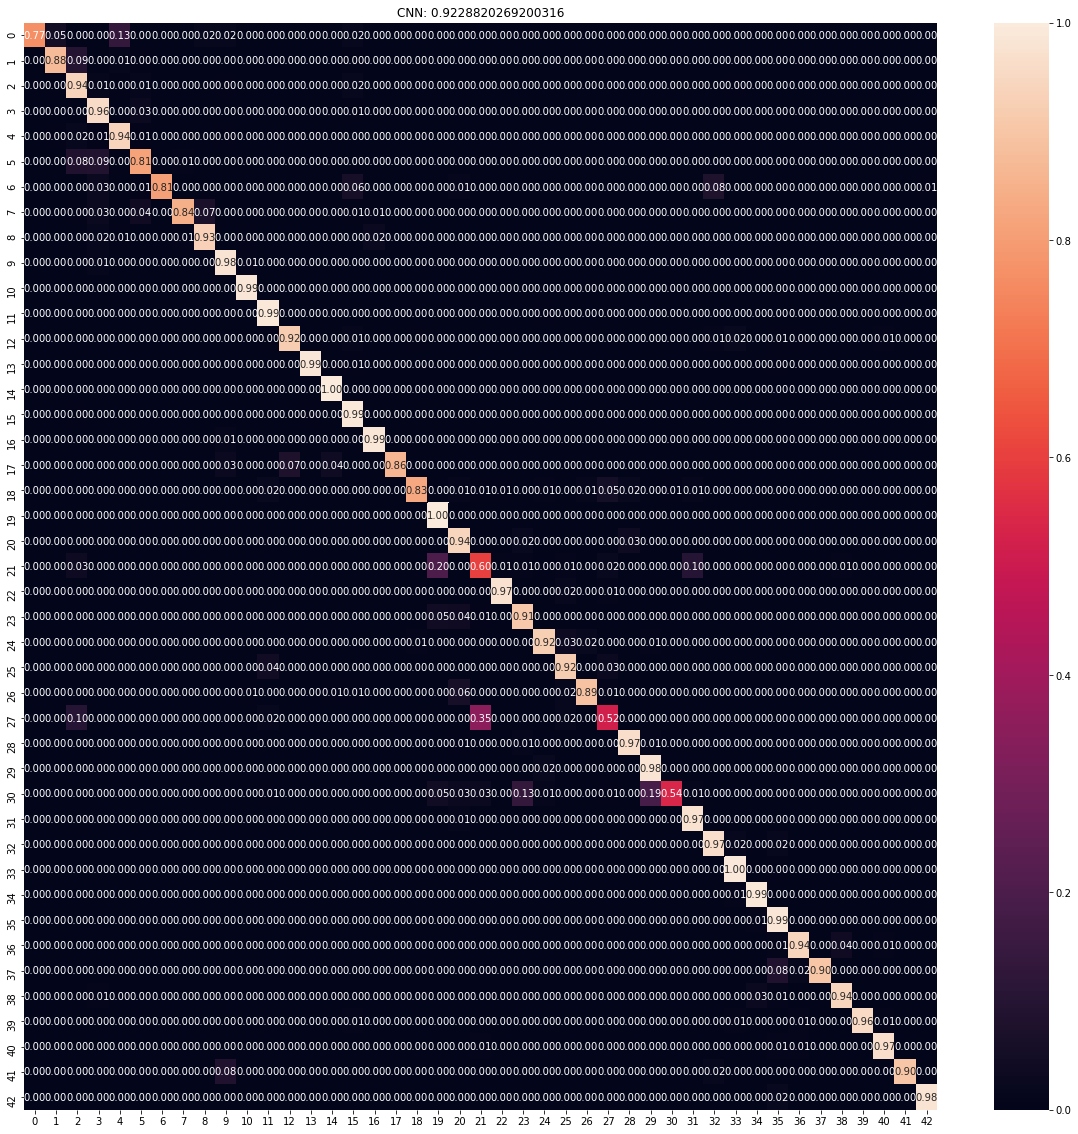

In [41]:
cnn_heatmap(cnn2,X_test_tr,y_test_tr)

As seen above, our second model performs better than the first. After changes we see a higher peak validation accuracy however there still may be a bit of evidence suggesting overtraining in further epochs. That being said, the model still performs to the expectations and exceeds that of the first model. However, there would still need to be some more improvement before considering it for autonomous driving.

### Architecture 2 - Param Set 1

In [43]:
%%time
'''
INIT ARCHCITECTURE
'''
img_sz = 32 # width and height of img

cnn3 = Sequential()

# 1st Convolutional Layer w/pool
cnn3.add(Conv2D(filters=64, 
                kernel_size=(5,5), 
                padding='same',
                data_format="channels_first"))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first"))

# 2nd Convolutional Layer w/pool
cnn3.add(Conv2D(filters=128, 
                  kernel_size=(5,5), 
                  padding='same',
                  data_format="channels_first"))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first"))

# 3rd Convolutional Layer
cnn3.add(Conv2D(filters=256, 
                 kernel_size=(4,4),  
                 padding='same',
                 data_format="channels_first"))
cnn3.add(Activation('relu'))

# 4th Convolutional Layer
cnn3.add(Conv2D(filters=512, 
                 kernel_size=(3,3),  
                 padding='same',
                 data_format="channels_first"))
cnn3.add(Activation('relu'))

# 5th Convolutional Layer w/pool
cnn3.add(Conv2D(filters=256, 
                 kernel_size=(3,3), 
                 padding='same',
                 data_format="channels_first"))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first"))


# Passing to fully connected layer
cnn3.add(Flatten())
# 1st fully Connected Layer
cnn3.add(Dense(512, activation='linear'))
# cnn3.add(Activation('relu'))
cnn3.add(Dropout(0.4))

# 2nd fully connected Layer
cnn3.add(Dense(256, activation='linear'))
# cnn3.add(Activation('relu'))
cnn3.add(Dropout(0.4))

# 3rd fully connected Layer
cnn3.add(Dense(128, activation='linear'))
# cnn3.add(Activation('relu'))
cnn3.add(Dropout(0.4))

# Output Layer
cnn3.add(Dense(43, activation='softmax'))
# cnn3.add(Activation('softmax'))

cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy']) 

Wall time: 15.5 ms


In [44]:
SVG(model_to_dot(cnn3, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [46]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn3_hist = cnn3.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
        )

Train on 96989 samples, validate on 12630 samples
Epoch 1/15
96989/96989 [==============================] - 82s 843us/step - loss: 0.0324 - accuracy: 0.0318 - val_loss: 0.0227 - val_accuracy: 0.0095
Epoch 2/15
96989/96989 [==============================] - 81s 838us/step - loss: 0.0227 - accuracy: 0.0235 - val_loss: 0.0227 - val_accuracy: 0.0119
Epoch 3/15
96989/96989 [==============================] - 81s 837us/step - loss: 0.0227 - accuracy: 0.0242 - val_loss: 0.0227 - val_accuracy: 0.0095
Epoch 4/15
96989/96989 [==============================] - 82s 843us/step - loss: 0.0227 - accuracy: 0.0221 - val_loss: 0.0227 - val_accuracy: 0.0570
Epoch 5/15
96989/96989 [==============================] - 82s 840us/step - loss: 0.0227 - accuracy: 0.0237 - val_loss: 0.0227 - val_accuracy: 0.0380
Epoch 6/15
96989/96989 [==============================] - 81s 840us/step - loss: 0.0227 - accuracy: 0.0235 - val_loss: 0.0227 - val_accuracy: 0.0048
Epoch 7/15
96989/96989 [==============================] 

Text(0.5, 0, 'epochs')

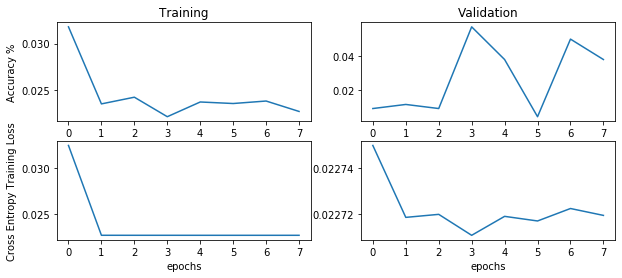

In [47]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn3_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn3_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn3_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn3_hist.history['val_loss'])
plt.xlabel('epochs')

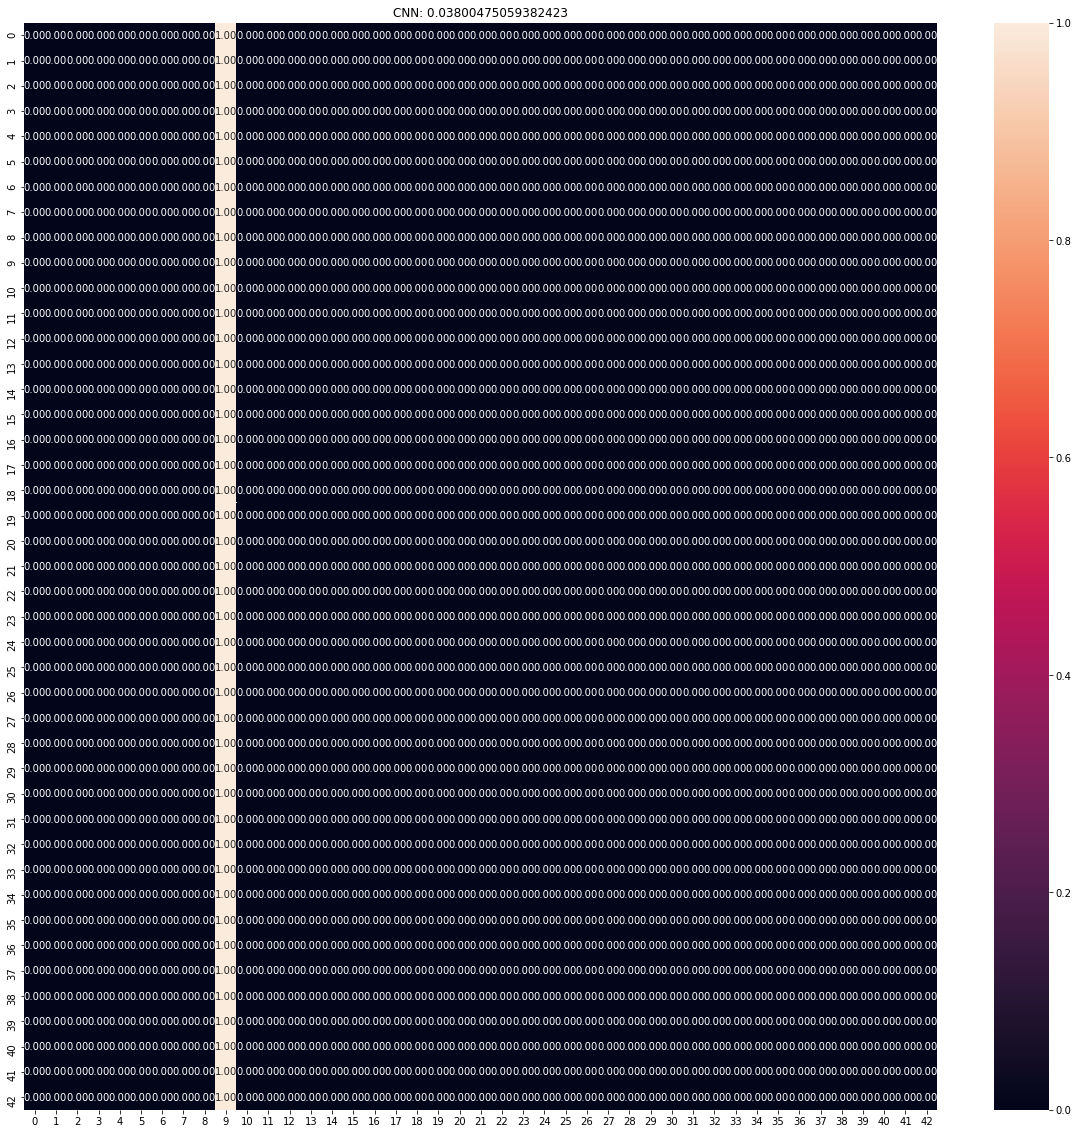

In [48]:
cnn_heatmap(cnn3,X_test_tr,y_test_tr)

### Architecture 2 - Param Set 2

In [38]:
'''
INIT ARCHCITECTURE
'''
img_sz = 32 # width and height of img

cnn3 = Sequential()

# 1st Convolutional Layer w/pool
cnn3.add(Conv2D(filters=128, 
                kernel_size=(3,3), 
                padding='same',
                data_format="channels_first"))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(3,3), data_format="channels_first"))

# 2nd Convolutional Layer w/pool
cnn3.add(Conv2D(filters=256, 
                  kernel_size=(5,5), 
                  padding='same',
                  data_format="channels_first"))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first"))

# 3rd Convolutional Layer
cnn3.add(Conv2D(filters=512, 
                 kernel_size=(4,4),  
                 padding='same',
                 data_format="channels_first"))
cnn3.add(Activation('relu'))

# 4th Convolutional Layer
cnn3.add(Conv2D(filters=256, 
                 kernel_size=(3,3),  
                 padding='same',
                 data_format="channels_first"))
cnn3.add(Activation('relu'))

# 5th Convolutional Layer w/pool
cnn3.add(Conv2D(filters=128, 
                 kernel_size=(3,3), 
                 padding='same',
                 data_format="channels_first"))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first"))


# Passing to fully connected layer
cnn3.add(Flatten())
# 1st fully Connected Layer
cnn3.add(Dense(256, activation='linear'))
# cnn3.add(Activation('relu'))
cnn3.add(Dropout(0.4))

# 2nd fully connected Layer
cnn3.add(Dense(128, activation='linear'))
# cnn3.add(Activation('relu'))
cnn3.add(Dropout(0.4))

# 3rd fully connected Layer
cnn3.add(Dense(64, activation='linear'))
# cnn3.add(Activation('relu'))
cnn3.add(Dropout(0.4))

# Output Layer
cnn3.add(Dense(43, activation='softmax'))
# cnn3.add(Activation('softmax'))

cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy']) 

In [39]:
SVG(model_to_dot(cnn4, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [40]:
%%time
# DATA FORMAT -> (channels, x-dim, y-dim)
cnn4_hist = cnn4.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Train on 86989 samples, validate on 12630 samples
Epoch 1/15
86989/86989 [==============================] - 72s 825us/step - loss: 0.0227 - accuracy: 0.0232 - val_loss: 0.0227 - val_accuracy: 0.0356
Epoch 2/15
86989/86989 [==============================] - 72s 828us/step - loss: 0.0227 - accuracy: 0.0219 - val_loss: 0.0227 - val_accuracy: 0.0546
Epoch 3/15
86989/86989 [==============================] - 73s 844us/step - loss: 0.0227 - accuracy: 0.0218 - val_loss: 0.0227 - val_accuracy: 0.0356
Epoch 4/15
86989/86989 [==============================] - 72s 822us/step - loss: 0.0227 - accuracy: 0.0219 - val_loss: 0.0227 - val_accuracy: 0.0594
Epoch 5/15
86989/86989 [==============================] - 83s 950us/step - loss: 0.0227 - accuracy: 0.0224 - val_loss: 0.0227 - val_accuracy: 0.0071
Wall time: 6min 13s


Text(0.5, 0, 'epochs')

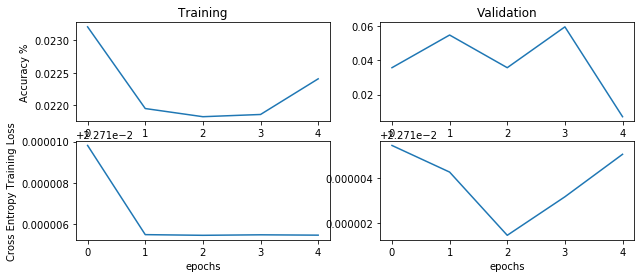

In [41]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(cnn4_hist.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(cnn4_hist.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(cnn4_hist.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(cnn4_hist.history['val_loss'])
plt.xlabel('epochs')

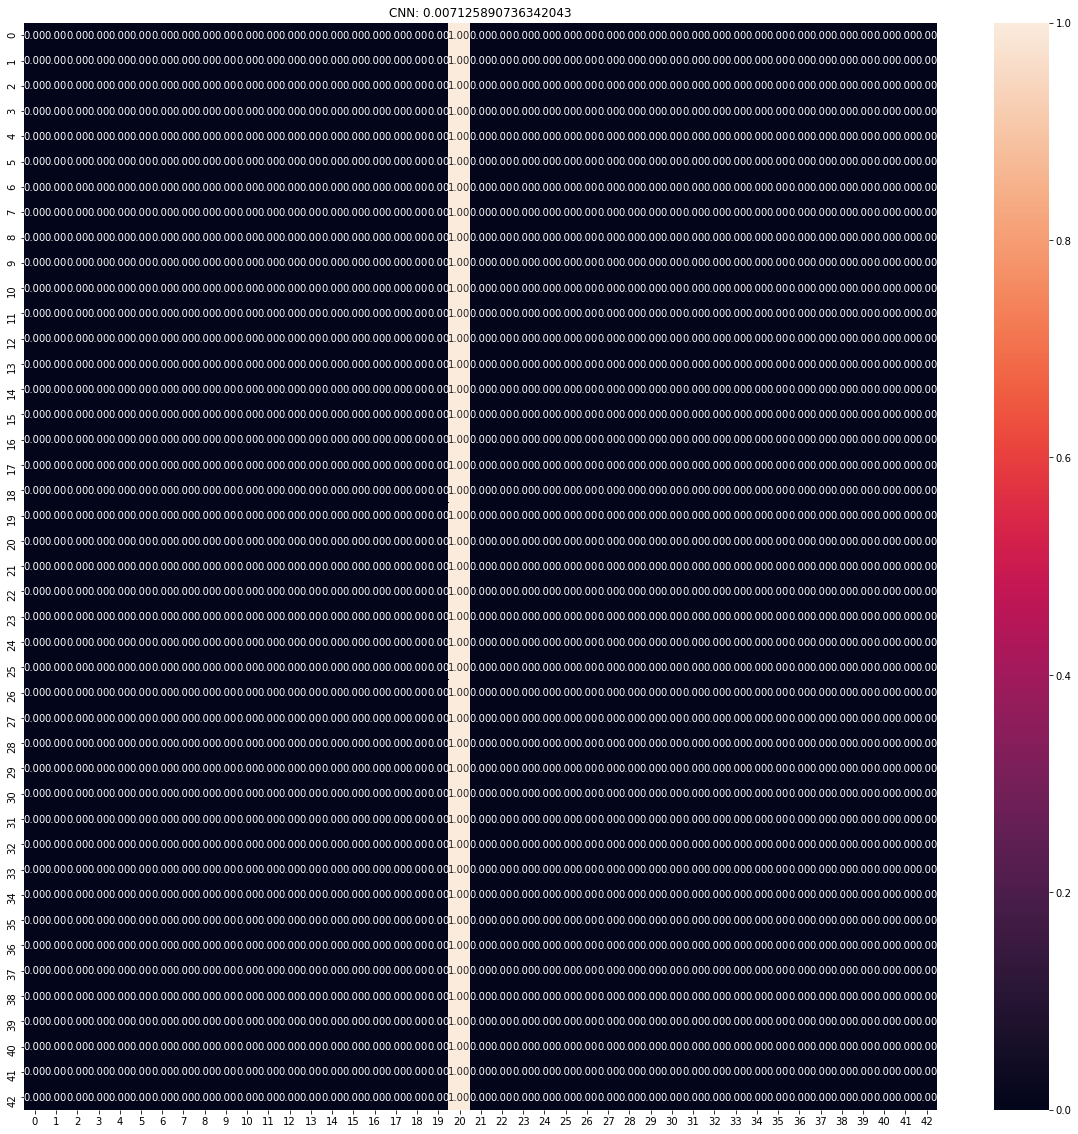

In [42]:
cnn_heatmap(cnn4,X_test_tr,y_test_tr)

### MLP Comparison

In [49]:
%%time

y_train_ohe_tr = keras.utils.to_categorical(y_train_tr, 43)
y_test_ohe_tr = keras.utils.to_categorical(y_test_tr, 43)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add(Flatten())
mlp.add( Dense(input_dim=X_train_tr.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(43) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

Wall time: 209 ms


In [53]:
mlp.fit(X_train_tr, y_train_ohe_tr, 
        batch_size=32, epochs=50, 
        shuffle=True, verbose=1,
        )

Epoch 1/75
86989/86989 [==============================] - 9s 106us/step - loss: 0.0026 - accuracy: 0.9300
Epoch 2/75
86989/86989 [==============================] - 9s 102us/step - loss: 0.0026 - accuracy: 0.9297
Epoch 3/75
86989/86989 [==============================] - 8s 95us/step - loss: 0.0025 - accuracy: 0.9310
Epoch 4/75
86989/86989 [==============================] - 9s 101us/step - loss: 0.0025 - accuracy: 0.9305
Epoch 5/75
86989/86989 [==============================] - 8s 96us/step - loss: 0.0025 - accuracy: 0.9310
Epoch 6/75
86989/86989 [==============================] - 8s 95us/step - loss: 0.0025 - accuracy: 0.9323
Epoch 7/75
86989/86989 [==============================] - 8s 97us/step - loss: 0.0025 - accuracy: 0.9335
Epoch 8/75
86989/86989 [==============================] - 8s 97us/step - loss: 0.0025 - accuracy: 0.9336
Epoch 9/75
86989/86989 [==============================] - 8s 97us/step - loss: 0.0025 - accuracy: 0.9324
Epoch 10/75
86989/86989 [===========================

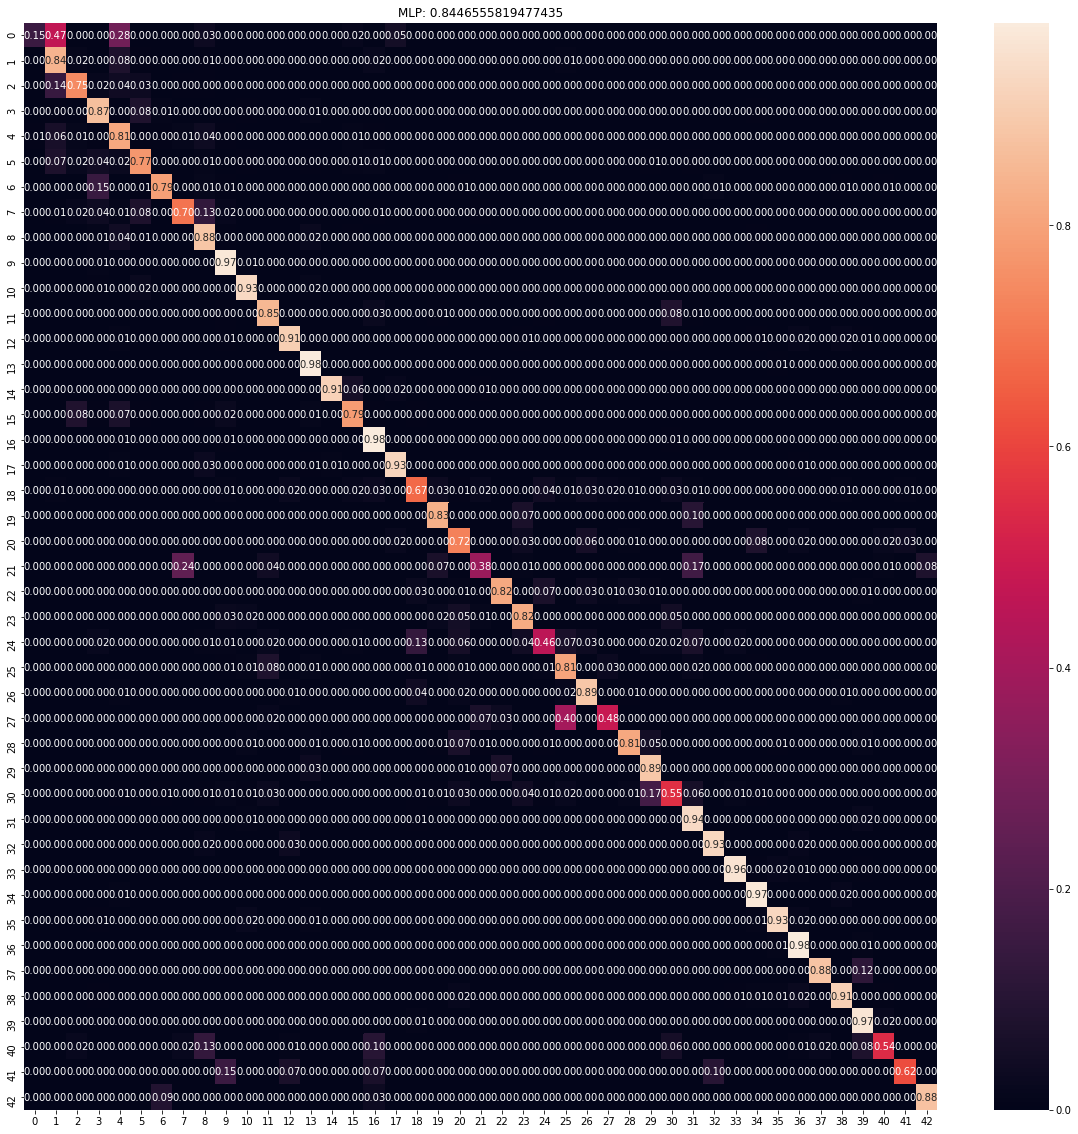

In [58]:
compare_mlp_cnn(cnn2,mlp,X_test_tr,y_test_tr)